# Figures for the paper

In [1]:
from viz import get_result_dfs
from elk_generalization.utils import get_quirky_model_name

models = [
    "EleutherAI/pythia-410m",
    "EleutherAI/pythia-1b",
    "EleutherAI/pythia-1.4b",
    "EleutherAI/pythia-2.8b",
    "EleutherAI/pythia-6.9b",
    "EleutherAI/pythia-12b",
    "meta-llama/Llama-2-7b-hf",
    "mistralai/Mistral-7B-v0.1",
]
model_scales = {
    "pythia-410m": 0.41,
    "pythia-1b": 1,
    "pythia-1.4b": 1.4,
    "pythia-2.8b": 2.8,
    "pythia-6.9b": 6.9,
    "pythia-12b": 12,
    "Llama-2-7b-hf": 7,
    "Mistral-7B-v0.1": 7,
}
method_titles = {
    "lr": "LogR",
    "mean-diff": "Diff-in-means",
    "mean-diff-on-pair": "Diff-in-means on contrast pair",
    "lda": "LDA",
    "lr-on-pair": "LogR on contrast pair",
    "ccs": "CCS",
    "crc": "CRC",
}

ds_names = [
    "capitals",
    "hemisphere",
    "population",
    "sciq",
    "sentiment",
    "nli",
    "authors",
    "addition",
    "subtraction",
    "multiplication",
    "modularaddition",
    "squaring",
]

ds_abbrevs = {
    "capitals": "cap",
    "hemisphere": "hem",
    "population": "pop",
    "sciq": "sciq",
    "sentiment": "snt",
    "nli": "nli",
    "authors": "aut",
    "addition": "add",
    "subtraction": "sub",
    "multiplication": "mul",
    "modularaddition": "mod",
    "squaring": "sqr",
}
root = "../../experiments/"


/mnt/ssd-1/alexm/miniconda3/envs/elkg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Qualitative differences

In [2]:
plot_ds_names = ds_names.copy()
plot_ds_names.remove("authors")  # authors is only False for disagreements
plot_models = models # ["mistralai/Mistral-7B-v0.1"]
fr, to = "A", "B"
filter_by = "disagree"
weak_only = False
metric = "auroc"
methods = ["lr",]
templatization_method = "first"
standardize_templates = False
full_finetuning = False
rs = dict()
for reporter in methods:
    rs[reporter] = get_result_dfs(plot_models, fr, to, plot_ds_names, label_col="alice_label", filter_by=filter_by, metric=metric, reporter=reporter, root_dir=root, weak_only=weak_only, templatization_method=templatization_method, standardize_templates=standardize_templates, full_finetuning=full_finetuning)

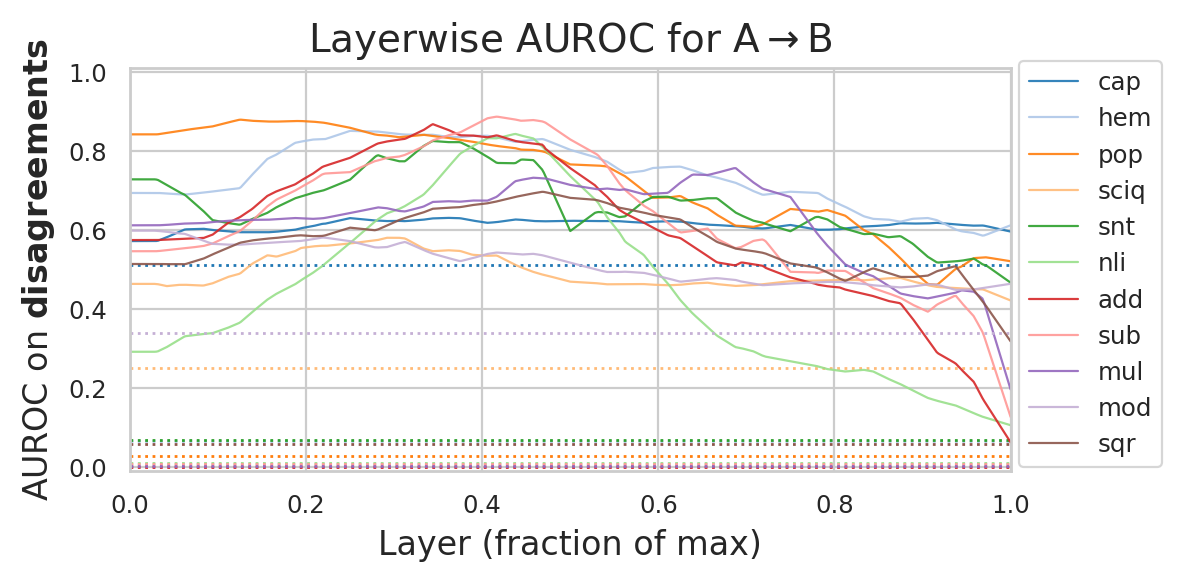

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(6, 3), dpi=200)

for i, method in enumerate(methods):
    avg_reporter_results, per_ds_results_dfs, all_result_dfs, avg_lm_result, per_ds_lm_result_dfs, lm_results = rs[method]
    colors = sns.color_palette("tab20", len(per_ds_results_dfs))
    for j, (key, result_df, lm_result) in enumerate(zip(per_ds_results_dfs.keys(), per_ds_results_dfs.values(), per_ds_lm_result_dfs.values())):
        ax.plot(result_df["layer_frac"], result_df[metric], alpha=0.9, color=colors[j], linewidth=0.8, label=ds_abbrevs[key])
        ax.hlines(lm_result, 0, 1, color=colors[j], linewidth=1, linestyle=":")

    # turn legend on
    if i == 0:
        ax.legend(loc=[1.01, 0.01])

    if i % 3 == 0:
        lab = {
            "disagree": f"{metric.upper()}" + " on $\\bf{disagreements}$",
            "agree": f"{metric.upper()}" + " on $\\bf{agreements}$",
            "all": f"{metric.upper()}" + " on $\\bf{all\\ examples}$",
        }[filter_by]
        ax.set_ylabel(lab, fontsize=12)
    
    if i == 0:
        ax.set_xlabel("Layer (fraction of max)", fontsize=12)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.01, 1.01)
    if i == 3:
        ax.legend(loc="lower left")

plt.title(f"Layerwise {metric.upper()} for {fr}$\\to${to}" + (" weak only" if weak_only else ""), fontsize=14)
plt.tight_layout()
os.makedirs("../../figures", exist_ok=True)
plt.savefig(f"../../figures/layerwise_auroc_qualitative_{fr}_{to}.pdf")
plt.show()

# Random classifier

In [ ]:
import torch
from pathlib import Path
from viz import interpolate
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from elk_generalization.utils import get_quirky_model_name

# set color palette
palette = sns.color_palette("tab20", 20)
sns.set_palette(palette)
fr, to = "AE", "BH"
against_col = "alice_labels"
root = Path("../../experiments")
ceiling_root = Path("../../experiments-ceiling")
plt.figure(figsize=(5, 3.1), dpi=100)
cmap = plt.get_cmap('coolwarm')
random_ds_names = ds_names.copy()
random_ds_names.remove("population")


for q_idx in [30, 20, 17, 16, 15, 14, 13, 10, 0,]:
    layers_dict = dict()
    aurocs_dict = dict()
    for model in models:
        for ds_name in random_ds_names:
            model_last = model.split("/")[-1]
            try:
                quirky_model_id, quirky_model_last = get_quirky_model_name(ds_name, model_last, templatization_method=templatization_method, standardize_templates=standardize_templates, full_finetuning=full_finetuning)
                results = torch.load(root / quirky_model_last / to / "test" / f"{fr}_random_aucs_against_{against_col}.pt", map_location="cpu")
            except FileNotFoundError as e:
                print(f"skipping {quirky_model_id}", e)
                continue
            aurocs = [list(results[i]["quantiles"].values())[q_idx] for i in range(len(results))]
            
            if not np.isfinite(np.array(aurocs)).all():
                print(f"skipping {quirky_model_id} due to NaN")
                continue
            layers_dict[(model, ds_name)] = np.arange(len(results))
            aurocs_dict[(model, ds_name)] = aurocs

    layer_fracs, avg_aurocs = interpolate(list(layers_dict.values()), list(aurocs_dict.values()), layers_dict.keys(), 501)

    q = list(results[0]["quantiles"].keys())[q_idx]
    lab = "$2^{" + str(int(np.log2(q))) + "}$" if q <= 0.5 else "$1-2^{" + str(int(np.log2(1 - q))) + "}$"
    plt.plot(layer_fracs, avg_aurocs, label=lab, linewidth=2, color=cmap(q))

avg_reporter_results, _, _, _, _, _ = get_result_dfs(models, "B", "BH", random_ds_names, label_col="alice_label", filter_by="all", metric="auroc", reporter="lr", root_dir=ceiling_root, weak_only=False)
plt.plot(avg_reporter_results["layer_frac"], avg_reporter_results["auroc"], label="LogR ceiling", linewidth=2, color="black", linestyle="--")

# turn on horizontal grid
plt.grid(axis="y")

plt.legend(loc=[1.07, -0.1], title="quantile", fontsize=11)
plt.ylim(-0.01, 1.01)
plt.xlim(0, 1)
plt.xlabel("Layer (fraction of max)", fontsize=13)
plt.ylabel("AUROC on\nall examples", fontsize=13)
plt.tight_layout()
plt.title(f"{fr}$\\to${to} random baseline", fontsize=13)
plt.savefig(f"../../figures/layerwise_auroc_random_{fr}_{to}.pdf", bbox_inches="tight")

# Barplot evaluating difficulty metrics

In [ ]:
# exclude population
difficulty_ds_names = ds_names.copy()
difficulty_ds_names.remove("population")
# construct a dataframe with columns: ds_name, lm_auroc, character, model_name, difficulty

records = []
for character in ["A", "B"]:
    for difficulty in ["E", "H"]:
        to = character + difficulty
        dummy1, dummy2 = "AE", "lr"
        _, _, _, _, _, lm_results = get_result_dfs(models, dummy1, to, difficulty_ds_names, label_col="label", filter_by="all", metric="auroc", reporter=dummy2, root_dir=root, weak_only=False)
        for ds_name in difficulty_ds_names:
            for model_name in models:
                records.append({
                    "ds_name": ds_abbrevs[ds_name],
                    "lm_auroc": lm_results[(model_name, ds_name)],
                    "character": character,
                    "model_name": model_name,
                    "difficulty": difficulty,
                })

import pandas as pd
df = pd.DataFrame.from_records(records)
df["difficulty"] = df["difficulty"].replace({"E": "easy", "H": "hard"})
df["character"] = df["character"].replace({"A": "Alice", "B": "Bob"})

AE_avg = df[(df["character"] == "Alice") & (df["difficulty"] == "easy")]["lm_auroc"].mean()
AH_avg = df[(df["character"] == "Alice") & (df["difficulty"] == "hard")]["lm_auroc"].mean()
print(f"Alice easy: {AE_avg:.3f}, Alice hard: {AH_avg:.3f}")


In [ ]:
# plot
sns.set_style("whitegrid")
sns.set_context("paper")
fig, axs = plt.subplots(1, 2, figsize=(8, 3), dpi=100)

for character, ax in zip(["Alice", "Bob"], axs):
    sub_df = df[df["character"] == character]
    sns.barplot(data=sub_df, x="ds_name", y="lm_auroc", hue="difficulty", ax=ax, legend=True, linewidth=2)

    # rotate x labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        # right align
        tick.set_horizontalalignment("right")
    ax.set_title(f"{character} LM AUROC", fontsize=13)
    ax.set_ylabel(f"AUROC against {character}'s labels", fontsize=13)
    ax.set_xlabel("")

plt.tight_layout()
plt.savefig("../../figures/lm_auroc_by_difficulty.pdf", bbox_inches="tight")

# All transfer experiments for the appendix

In [ ]:
exps = [("A", "A", "disagree"), ("A", "B", "disagree"), ("B", "B", "disagree"), ("B", "A", "disagree"), 
        ("A", "AH", "all"), ("AE", "AH", "all"), ("A", "BH", "all"), ("AE", "BH", "all")]
metric = "auroc"
ds_name = "nli"
reporter = "mean-diff"
root = "../../experiments/"
rs = dict()
for i, (fr, to, filter_by) in enumerate(exps):
    rs[(fr, to)] = get_result_dfs(models, fr, to, [ds_name], label_col="alice_label", filter_by=filter_by, metric=metric, reporter=reporter, root_dir=root)

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MultipleLocator

sns.set_style("whitegrid")
sns.set_context("paper")

# get viridis colors in a list (not css4)
cmap_name = "winter"
cmap = lambda x: plt.get_cmap(cmap_name)( (np.log(x) - np.log(0.41)) / (np.log(12) - np.log(0.41)) )

fig, axes = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(10, 7), dpi=200)

for i, (fr, to, filter_by) in enumerate(exps):
    ax = axes[i // 2][i % 2]
    avg_reporter_results, _, results_dfs, avg_lm_result, _, lm_results = rs[(fr, to)]
    for key, result_df, lm_result in zip(results_dfs.keys(), results_dfs.values(), lm_results.values()):
        ax.plot(result_df["layer_frac"], result_df[metric], alpha=0.4, color=cmap(model_scales[key[0].split("/")[-1]]), linewidth=0.8)
        
    ax.plot(avg_reporter_results["layer_frac"], avg_reporter_results[metric], label="LR probe", linewidth=2, color="fuchsia")

    ax.hlines(avg_lm_result, 0, 1, label="Final layer LM output", color="dodgerblue", linewidth=2, linestyle="-")
    ax.hlines(0.5, 0, 1, label="random", color="black", linewidth=0.5, linestyle="--")

    if i % 2 == 0:
        lab = {
            "disagree": f"{metric.upper()}" + " on\n$\\bf{disagreements}$",
            "agree": f"{metric.upper()}" + " on\n$\\bf{agreements}$",
            "all": f"{metric.upper()}" + " on\n$\\bf{all\\ examples}$",
        }[filter_by]
        ax.set_ylabel(lab, fontsize=11.5)
    if i >= 6:
        ax.set_xlabel("Layer (fraction of max)", fontsize=12)
    if fr == to:
        title = fr.title() + " (no transfer)"
    else:
        title = (f"{fr} → {to}")
    ax.set_title(title, fontsize=13)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.01, 1.01)
    if i == 0:
        ax.legend(loc="lower right")

    ax.yaxis.set_major_locator(MultipleLocator(0.25))
plt.suptitle(f"{ds_name.capitalize()} ({method_titles[reporter]})", fontsize=16)
plt.tight_layout()

# # make a vertical colorbar
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=np.log(0.41), vmax=np.log(12))
sm = plt.cm.ScalarMappable(cmap=cmap_name, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation="vertical", pad=0.1, aspect=40)
cbar.ax.set_ylabel("Model size (B parameters)", fontsize=12)
cbar.ax.yaxis.set_label_position("left")
cbar.ax.yaxis.set_ticks_position("left")
cbar.ax.tick_params(axis="y", labelsize=12, rotation=0)
cbar.set_ticks(np.log(np.array([0.41, 1, 2.8, 7, 12])))
cbar.ax.set_yticklabels(["0.41", "1", "2.8", "7", "12"])


os.makedirs("../../figures", exist_ok=True)
plt.savefig(f"../../figures/layerwise_auroc_{reporter}_{ds_name}.pdf", bbox_inches="tight")
plt.show()

# Scatter plot for ID and OOD performance

In [ ]:
from collections import defaultdict

ds_names_without_pop = ds_names.copy()
ds_names_without_pop.remove("population")
contrast_pairs = True
exps = {
    "lr-on-pair": [("AE", "AE"), ("AE", "BH")],
    "ccs": [("AE", "AE"), ("AE", "BH")],
    "crc": [("AE", "AE"), ("AE", "BH")],
} if contrast_pairs else {
    "lr": [("AE", "AE"), ("AE", "BH")],
    "mean-diff": [("AE", "AE"), ("AE", "BH")],
    "lda": [("AE", "AE"), ("AE", "BH")],
}
id_aurocs = defaultdict(list)
ood_aurocs = defaultdict(list)
for method in exps:
    for i, (fr, to) in enumerate(exps[method]):
        try:
            _, _, result_dfs, _, _, _ = get_result_dfs(models, fr, to, ds_names_without_pop, filter_by="all", label_col="alice_label", reporter=method)
            for model in models:
                for ds_name in ds_names_without_pop:
                    aucs = result_dfs[(model, ds_name)]["auroc"].values
                    if to == "AE" and fr == "AE":
                        id_aurocs[method].extend(aucs)
                    elif to == "BH" and fr == "AE":
                        ood_aurocs[method].extend(aucs)
                    else:
                        raise ValueError("Unexpected experiment")

        except KeyError:
            print(f"Experiment {fr} → {to} not found for method {method} with model {model} and ds_name {ds_name}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
colors = sns.color_palette("Set2")

plt.figure(figsize=(4, 4), dpi=150)
n_show = 1000
for i, method in enumerate(id_aurocs):
    sample = np.random.choice(len(id_aurocs[method]), n_show, replace=False)
    for j, idx in enumerate(sample):
        plt.scatter(id_aurocs[method][idx], ood_aurocs[method][idx], label=method_titles[method] if j == 0 else None, alpha=0.5, s=5, zorder=np.random.randint(0, 6), c=colors[i])
plt.plot([0, 2], [0, 2], color="black", linestyle="--", linewidth=0.5)
plt.axhline(0.5, color="grey", linestyle="--", linewidth=0.5)
plt.xlim(0.35, 1.02)
plt.ylim(-0.02, 1.02)
plt.xlabel("AUROC on AE (no transfer)", fontsize=13)
plt.ylabel("Transfer AUROC for AE$\\to$BH", fontsize=13)
os.makedirs("../../figures", exist_ok=True)
plt.legend(fontsize=12, loc="lower left")
title = "Probing on contrast pair" if contrast_pairs else "Probing on final prompt token"
plt.title(title, fontsize=13)
plt.tight_layout()
plt.savefig(f"../../figures/transfer_scatter_{'_'.join(exps.keys())}.pdf")
plt.show()

# All transfer results at EIL bar plot

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from viz import earliest_informative_layer
import os
import numpy as np


transfers_all = [
        (("A", "A"), ("A", "B")),
        (("B", "B"), ("B", "A")),
        (("A", "AH"), ("AE", "AH")),
        (("A", "BH"), ("AE", "BH")),
]
filter_bys = ["disagree", "disagree", "all", "all"]
methods = ["lm", "lr", "mean-diff", "lda", "lr-on-pair", "mean-diff-on-pair", "ccs", "crc"]
dfs = []
for frame, (transfers, filter_by) in enumerate(zip(transfers_all, filter_bys)):
    current_ds_names = ds_names.copy()
    if filter_by == "disagree":
        current_ds_names.remove("authors")  # authors only has false disagreements
    elif any(any("H" in distr for distr in transfer) for transfer in transfers):
        current_ds_names.remove("population")  # population only has false labels on H

    print("CURRENT TRANSFER", transfers)
    try:
        # make a df with a column for auroc on middle layer, and a column for method, and column for transfer,
        # where each row is a model/template/method combo
        df = []
        for method in methods:
            for (fr, to) in transfers:
                if method == "lm":
                    _, _, _, _, _, lm_results = get_result_dfs(models, fr, to, current_ds_names, filter_by=filter_by, label_col="alice_label", root_dir=root, reporter="lr")  # lr is dummy
                    for model in models:
                        for ds_name in current_ds_names:
                            if (model, ds_name) not in lm_results:
                                continue
                            df.append({
                                "auroc": lm_results[(model, ds_name)],
                                "method": "Target distr\nLM output",
                                "transfer": f"{fr}$\\to${to}",
                            })
                else:
                    _, _, result_dfs, _, _, _ = get_result_dfs(models, fr, to, current_ds_names, filter_by=filter_by, label_col="alice_label", root_dir=root, reporter=method)
                    # pick layer on source distribution with all examples, measured against source labels
                    _, _, id_result_dfs, _, _, _ = get_result_dfs(models, fr, fr, current_ds_names, filter_by="all", label_col="label", reporter=method, root_dir=root)
                    for model in models:
                        for ds_name in current_ds_names:
                            if (model, ds_name) not in result_dfs or (model, ds_name) not in id_result_dfs:
                                print(f"Skipping {model}-{ds_name} due to missing data")
                                continue
                            if id_result_dfs[(model, ds_name)].isna().any().any():
                                print(f"Skipping {model}-{ds_name} due to NaN")
                                continue
                            layer_idx = earliest_informative_layer(id_result_dfs[(model, ds_name)], thresh=0.95)
                            auroc = result_dfs[(model, ds_name)]["auroc"].values[layer_idx]
                            df.append({
                                "auroc": auroc,
                                "method": method_titles[method].replace("LogR on contrast pair", "LogR on\ncont. pair").replace("Diff-in-means on contrast pair", "Diff-in-means\non cont. pair"),
                                "transfer": f"{fr}$\\to${to}",
                            })
    except FileNotFoundError as e:
        print(f"Experiment not found: {e}")
        continue
    
    df = pd.DataFrame(df)

    dfs.append(df)

CURRENT TRANSFER (('A', 'A'), ('A', 'B'))


In [ ]:
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(10, 5), dpi=150)

palette = ["slategray"] + sns.color_palette("Set2", n_colors=len(methods) - 1)
# hatches = ['/', ''] # if i == 0 else '' for i in range(len(methods) + 1)]
for frame, (df, filter_by) in enumerate(zip(dfs, filter_bys)):
    ax = axes[frame // 2][frame % 2]
    plt.sca(ax)
    sns.barplot(data=df, x="transfer", y="auroc", hue="method", legend=frame == 3, palette=palette, errorbar=None)

    # turn off legend
    if frame == 3:
        ax.get_legend().remove()
    ax.tick_params(labelsize=14)
    
    if filter_by == "all":
        plt.ylabel("AUROC on\n$\\bf{all\\ examples}$", fontsize=14)
    elif filter_by == "disagree":
        plt.ylabel("AUROC on\n$\\bf{disagreements}$", fontsize=14)
    else:
        raise ValueError("Unexpected filter_by value" + str(filter_by))
    plt.xlabel("")
    
    plt.axhline(0.5, color="black", linestyle="--", linewidth=0.5)
    plt.ylim(-0.01, 1.01)
    plt.title("$\\bf {(" +'abcd'[frame] + ")}$", fontsize=15)

# add legend to the right, spanning the full height
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', fontsize=14, bbox_to_anchor=(1.2, 0.5))


plt.tight_layout()
os.makedirs("../../figures", exist_ok=True)
plt.savefig("../../figures/transfer_barplot.pdf", bbox_inches="tight")
plt.show()

# Table of results

In [ ]:
def get_table(exps, models, transfer_ds_names, weak_floor_transfer, strong_ceil_transfer, EIL_dstr, caption, tab_label):
    
    # get "weak" and "strong" performances for PGR calculation
    def get_floor_ceil(fr, to):
        out = dict()
        _, _, probe_results, _, _, _ = get_result_dfs(models, fr, to, transfer_ds_names, filter_by="all", label_col="alice_label", reporter="lr")  # any reporter will do
        for ds_name in transfer_ds_names:
            # get final layer probe auroc for each model
            ds_avg_auc = sum(probe_results[(model, ds_name)]["auroc"].iloc[-1] for model in models) / len(models)
            out[ds_name] = ds_avg_auc
        return out
    weak_floor_by_ds = get_floor_ceil(*weak_floor_transfer)
    strong_ceil_by_ds = get_floor_ceil(*strong_ceil_transfer)

    weak_floor, strong_ceil = np.mean(list(weak_floor_by_ds.values())), np.mean(list(strong_ceil_by_ds.values()))

    summary_table = \
    """\\setlength{\\tabcolsep}{3.35pt}
    \\begin{table}[htbp]
        \\centering
        \\caption{""" + caption + """}
        \\label{""" + tab_label + """}
        \\begin{tabular}{lccccccccccc@{\hspace{14pt}}c}
            \\toprule\n"""
    summary_table += "         & " + " & ".join([f"\\textit{{{ds_abbrevs[ds]}}}" for ds in transfer_ds_names]) + " & \\textbf{avg} \\\\ \n" + \
                    "        \\midrule\n"

    auc_by_exp_and_ds = defaultdict(list)
    for method in exps:
        for i, (fr, to) in enumerate(exps[method]):
            method_title = method_titles[method].replace("LogR on contrast pair", "\\begin{tabular}[l]{@{}l@{}}LogR on\\\\cont. pair\\end{tabular}").replace("Diff-in-means on contrast pair", "\\begin{tabular}[l]{@{}l@{}}Diff-in-means\\\\on cont. pair\\end{tabular}")
            if fr == "all":
                summary_table += f"        {method_title} (all\\(\\to\\){to}) & "
            else:
                summary_table += f"        {method_title} & "

            _, _, result_dfs, _, _, lm_results = get_result_dfs(models, fr, to, transfer_ds_names, filter_by="all", label_col="alice_label", reporter=method)
            
            # we use alice's easy no transfer data to select the layer
            _, _, id_result_dfs, _, _, _ = get_result_dfs(models, EIL_dstr, EIL_dstr, transfer_ds_names, filter_by="all", label_col="alice_label", reporter=method)
            
            row_avg = 0
            for j, ds_name in enumerate(transfer_ds_names):
                ds_avg_auc = 0
                for model in models:
                    
                    layer_idx = earliest_informative_layer(id_result_dfs[(model, ds_name)], thresh=0.95)

                    auc = result_dfs[(model, ds_name)]["auroc"].values[layer_idx]
                    row_avg += auc
                    ds_avg_auc += auc
                
                ds_avg_auc /= len(models)
                auc_by_exp_and_ds[ds_name].append(ds_avg_auc)
                ds_avg_pgr = (ds_avg_auc - weak_floor_by_ds[ds_name]) / (strong_ceil_by_ds[ds_name] - weak_floor_by_ds[ds_name])
                summary_table += f"{ds_avg_pgr:.2f} & "

            row_avg /= len(transfer_ds_names) * len(models)
            avg_pgr = (row_avg - weak_floor) / (strong_ceil - weak_floor)
            summary_table += f"{avg_pgr:.2f} \\\\ \n"

    # avg row
    summary_table += "        \\midrule\n"
    summary_table += "        \\bf{avg} & "
    ova_avg_auc = 0
    for ds_name in transfer_ds_names:
        avg_auc = sum(auc_by_exp_and_ds[ds_name]) / len(auc_by_exp_and_ds[ds_name])
        ova_avg_auc += avg_auc
        avg_pgr = (avg_auc - weak_floor_by_ds[ds_name]) / (strong_ceil_by_ds[ds_name] - weak_floor_by_ds[ds_name])
        summary_table += f"{avg_pgr:.2f} & "
    ova_avg_auc /= len(transfer_ds_names)
    ova_avg_pgr = (ova_avg_auc - weak_floor) / (strong_ceil - weak_floor)
    summary_table += f"{ova_avg_pgr:.2f} \\\\ \n"

    # weak and strong results
    summary_table += "        \\midrule\n"
    for floorceil_name, (fr, to), floorceil_by_ds in [("weak floor", weak_floor_transfer, weak_floor_by_ds), ("strong ceil", strong_ceil_transfer, strong_ceil_by_ds)]:
        summary_table += f"        {floorceil_name} ({to}) & "
        cap_avg = 0
        for ds_name, ds_avg_auc in floorceil_by_ds.items():
            summary_table += f"{ds_avg_auc:.2f} & "
            cap_avg += ds_avg_auc
        cap_avg /= len(floorceil_by_ds)
        summary_table += f"{cap_avg:.2f} \\\\ \n"

    summary_table += "        \\bottomrule\n"
    summary_table += "    \\end{tabular}\n\\end{table}"
    return summary_table

In [ ]:
import numpy as np
from viz import earliest_informative_layer
from collections import defaultdict

exps = {
    "lr": [("AE", "BH")],
    "mean-diff": [("AE", "BH")],
    "lda": [("AE", "BH")],
    "lr-on-pair": [("AE", "BH")],
    "mean-diff-on-pair": [("AE", "BH")],
    "ccs": [("AE", "BH"), ("all", "BH"),],
    "crc": [("AE", "BH"), ("all", "BH"),],
}
EIL_dstr = "AE"

transfer_ds_names = ds_names.copy()
transfer_ds_names.remove("population")  # population only has false labels on H
transfer_models = models.copy()

weak_floor_transfer, strong_ceil_transfer = ("B", "BH"), ("A", "AH")
caption = "AE\\(\\to\\)BH transfer PGR broken down by probing method and dataset at the Earliest Informative Layer (\\ref{sec:selecting_a_layer}). The last two rows show weak floor and strong ceiling AUROC values used for PGR calculation. The best probing method recovers 75\\% of the difference between untruthful and truthful behavior. Note that the capitals and authors datasets have similar ceiling and floor performances, leading to noisy PGR values. Each reported PGR value is calculated by averaging AUROC values before finally taking the difference and ratio. Otherwise, the weak floor and strong ceiling estimates are noisy, often leading to small or negative denominators."
print(get_table(exps, transfer_models, transfer_ds_names, weak_floor_transfer, strong_ceil_transfer, EIL_dstr, caption, "tab:transfer"))

### Alice to Bob (without easy to hard)

In [ ]:
import numpy as np
from viz import earliest_informative_layer
from collections import defaultdict

exps = {
    "lr": [("A", "B")],
    "mean-diff": [("A", "B")],
    "lda": [("A", "B")],
    "lr-on-pair": [("A", "B")],
    "mean-diff-on-pair": [("A", "B")],
    "ccs": [("A", "B"),],
    "crc": [("A", "B"),],
}
EIL_dstr = "A"

transfer_ds_names = ds_names.copy()
transfer_ds_names.remove("population")  # population only has false labels on H

weak_floor_transfer, strong_ceil_transfer = ("B", "B"), ("A", "A")
caption = "A\\(\\to\\)B transfer PGR broken down by probing method and dataset like in Table~\\ref{tab:transfer}."
print(get_table(exps, models, transfer_ds_names, weak_floor_transfer, strong_ceil_transfer, EIL_dstr, caption, "tab:transfer2"))

# Table comparing methods

### Comparing with full fintuning

In [ ]:
import numpy as np
from collections import defaultdict
from viz import earliest_informative_layer

transfer_models = models.copy()
transfer_models.remove("EleutherAI/pythia-12b")
transfer_ds_names = ds_names.copy()
transfer_ds_names.remove("population")

exps = {
    "lr": [("AE", "BH")],
    "mean-diff": [("AE", "BH")],
    "lda": [("AE", "BH")],
    "lr-on-pair": [("AE", "BH")],
    "mean-diff-on-pair": [("AE", "BH")],
    "ccs": [("AE", "BH"), ("all", "BH"),],
    "crc": [("AE", "BH"), ("all", "BH"),],
}
EIL_dstr = "AE"

weak_floor_transfer, strong_ceil_transfer = ("B", "BH"), ("A", "AH")
caption = "Comparison of LoRA finetuning and full finetuning in terms of PGR on AE\\(\\to\\)BH transfer, averaged over all models except Pythia 12B (for cost reasons)."
tab_label = "tab:fullft"

summary_table = \
"""\\setlength{\\tabcolsep}{3.35pt}
\\begin{wrapfigure}{r}{0.5\\textwidth} 
    \\centering
    \\caption{""" + caption + """}
    \\label{""" + tab_label + """}
    \\begin{tabular}{lcc}
        \\toprule\n"""
summary_table += "         & rank-8 LoRA & full finetune \\\\ \n" + \
                "        \\midrule\n"

# get "weak" and "strong" performances for PGR calculation
def get_floor_ceil(fr, to, full_finetuning):
    out = dict()
    _, _, probe_results, _, _, _ = get_result_dfs(transfer_models, fr, to, transfer_ds_names, filter_by="all", label_col="alice_label", reporter="lr", full_finetuning=full_finetuning)  # any reporter will do
    for ds_name in transfer_ds_names:
        # get final layer probe auroc for each model
        ds_avg_auc = sum(probe_results[(model, ds_name)]["auroc"].iloc[-1] for model in transfer_models) / len(transfer_models)
        out[ds_name] = ds_avg_auc
    return out
weak_floor_by_ds = {full_ft: get_floor_ceil(*weak_floor_transfer, full_finetuning=full_ft) for full_ft in [False, True]}
strong_ceil_by_ds = {full_ft: get_floor_ceil(*strong_ceil_transfer, full_finetuning=full_ft) for full_ft in [False, True]}

weak_floor = {full_ft: np.mean(list(weak_floor_by_ds[full_ft].values())) for full_ft in [False, True]}
strong_ceil = {full_ft: np.mean(list(strong_ceil_by_ds[full_ft].values())) for full_ft in [False, True]}

auc_by_exp_and_temp = defaultdict(list)
for method in exps:
    for i, (fr, to) in enumerate(exps[method]):
        method_title = method_titles[method].replace("LogR on contrast pair", "\\begin{tabular}[l]{@{}l@{}}LogR on\\\\cont. pair\\end{tabular}").replace("Diff-in-means on contrast pair", "\\begin{tabular}[l]{@{}l@{}}Diff-in-means\\\\on cont. pair\\end{tabular}")
        if fr == "all":
            summary_table += f"        {method_title} (all\\(\\to\\){to}) "
        else:
            summary_table += f"        {method_title} "

        for ft in [False, True]:
            _, _, result_dfs, _, _, lm_results = get_result_dfs(transfer_models, fr, to, transfer_ds_names, filter_by="all", label_col="alice_label", reporter=method, full_finetuning=ft)
            
            # we use alice's easy no transfer data to select the layer
            _, _, id_result_dfs, _, _, _ = get_result_dfs(transfer_models, EIL_dstr, EIL_dstr, transfer_ds_names, filter_by="all", label_col="alice_label", reporter=method, full_finetuning=ft)

            avg_over_datasets = 0        
            for j, ds_name in enumerate(transfer_ds_names):
                for model in transfer_models:
                    
                    layer_idx = earliest_informative_layer(id_result_dfs[(model, ds_name)], thresh=0.95)

                    auc = result_dfs[(model, ds_name)]["auroc"].values[layer_idx]
                    avg_over_datasets += auc

            avg_over_datasets /= len(transfer_ds_names) * len(transfer_models)
            auc_by_exp_and_temp[ft].append(avg_over_datasets)
            avg_pgr = (avg_over_datasets - weak_floor[ft]) / (strong_ceil[ft] - weak_floor[ft])
            summary_table += f"& {avg_pgr:.2f}"
        summary_table += " \\\\ \n"

# avg row
summary_table += "        \\midrule\n"
summary_table += "        \\bf{avg} "
for ft in [False, True]:
    avg_auc = sum(auc_by_exp_and_temp[ft]) / len(auc_by_exp_and_temp[ft])
    avg_pgr = (avg_auc - weak_floor[ft]) / (strong_ceil[ft] - weak_floor[ft])
    summary_table += f"& {avg_pgr:.2f}"
summary_table += " \\\\ \n"

# weak and strong results
summary_table += "        \\midrule\n"
for floorceil_name, (fr, to), floorceil_by_ds in [("weak floor", weak_floor_transfer, weak_floor_by_ds), ("strong ceil", strong_ceil_transfer, strong_ceil_by_ds)]:
    summary_table += f"        {floorceil_name} ({to}) "
    for ft in [False, True]:
        cap_avg = np.mean(list(floorceil_by_ds[ft].values()))
        summary_table += f"& {cap_avg:.2f} "
    summary_table += " \\\\ \n"

summary_table += "        \\bottomrule\n"
summary_table += "    \\end{tabular}\n\\end{wrapfigure}"
print(summary_table)

### Comparing template setups

In [ ]:

transfer_models = ["mistralail/Mistral-7B-v0.1",]
transfer_ds_names = ds_names.copy()
transfer_ds_names.remove("population")

exps = {
    "lr": [("AE", "BH")],
    "mean-diff": [("AE", "BH")],
    "lda": [("AE", "BH")],
    "lr-on-pair": [("AE", "BH")],
    "mean-diff-on-pair": [("AE", "BH")],
    "ccs": [("AE", "BH"), ("all", "BH"),],
    "crc": [("AE", "BH"), ("all", "BH"),],
}
EIL_dstr = "AE"

templatization_methods = {
    "single": ("first", False),
    "mix": ("random", False),
    "stdzd": ("random", True),
}

weak_floor_transfer, strong_ceil_transfer = ("B", "BH"), ("A", "AH")
caption = "Comparison of templatization setups in terms of PGR on AE\\(\\to\\)BH for Mistral 7B."
tab_label = "tab:template"

summary_table = \
"""\\setlength{\\tabcolsep}{3.35pt}
\\begin{wrapfigure}{r}{0.5\\textwidth} 
    \\centering
    \\caption{""" + caption + """}
    \\label{""" + tab_label + """}
    \\begin{tabular}{lccc}
        \\toprule\n"""
summary_table += "         & single & mixture & standardized \\\\ \n" + \
                "        \\midrule\n"

# get "weak" and "strong" performances for PGR calculation
def get_floor_ceil(fr, to, full_finetuning=False, templatization_method="first", standardize_templates=False):
    out = dict()
    _, _, probe_results, _, _, _ = get_result_dfs(transfer_models, fr, to, transfer_ds_names, filter_by="all", label_col="alice_label", reporter="lr", full_finetuning=full_finetuning, templatization_method=templatization_method, standardize_templates=standardize_templates)  # any reporter will do
    for ds_name in transfer_ds_names:
        # get final layer probe auroc for each model
        ds_avg_auc = sum(probe_results[(model, ds_name)]["auroc"].iloc[-1] for model in transfer_models) / len(transfer_models)
        out[ds_name] = ds_avg_auc
    return out
weak_floor_by_ds = {temp_name: get_floor_ceil(*weak_floor_transfer, templatization_method=tm, standardize_templates=st) for temp_name, (tm, st) in templatization_methods.items()}
strong_ceil_by_ds = {temp_name: get_floor_ceil(*strong_ceil_transfer, templatization_method=tm, standardize_templates=st) for temp_name, (tm, st) in templatization_methods.items()}

weak_floor = {temp_name: np.mean(list(weak_floor_by_ds[temp_name].values())) for temp_name in templatization_methods}
strong_ceil = {temp_name: np.mean(list(strong_ceil_by_ds[temp_name].values())) for temp_name in templatization_methods}

auc_by_exp_and_temp = defaultdict(list)
for method in exps:
    for i, (fr, to) in enumerate(exps[method]):
        method_title = method_titles[method].replace("LogR on contrast pair", "\\begin{tabular}[l]{@{}l@{}}LogR on\\\\cont. pair\\end{tabular}").replace("Diff-in-means on contrast pair", "\\begin{tabular}[l]{@{}l@{}}Diff-in-means\\\\on cont. pair\\end{tabular}")
        if fr == "all":
            summary_table += f"        {method_title} (all\\(\\to\\){to}) "
        else:
            summary_table += f"        {method_title} "

        for tname, (tm, st) in templatization_methods.items():
            _, _, result_dfs, _, _, lm_results = get_result_dfs(transfer_models, fr, to, transfer_ds_names, filter_by="all", label_col="alice_label", reporter=method, full_finetuning=False, templatization_method=tm, standardize_templates=st)
            
            # we use alice's easy no transfer data to select the layer
            _, _, id_result_dfs, _, _, _ = get_result_dfs(transfer_models, EIL_dstr, EIL_dstr, transfer_ds_names, filter_by="all", label_col="alice_label", reporter=method, full_finetuning=False, templatization_method=tm, standardize_templates=st)

            avg_over_datasets = 0        
            for j, ds_name in enumerate(transfer_ds_names):
                for model in transfer_models:
                    
                    layer_idx = earliest_informative_layer(id_result_dfs[(model, ds_name)], thresh=0.95)

                    auc = result_dfs[(model, ds_name)]["auroc"].values[layer_idx]
                    avg_over_datasets += auc
                
            avg_over_datasets /= len(transfer_ds_names) * len(transfer_models)
            auc_by_exp_and_temp[tname].append(avg_over_datasets)
            avg_pgr = (avg_over_datasets - weak_floor[tname]) / (strong_ceil[tname] - weak_floor[tname])
            summary_table += f"& {avg_pgr:.2f} "
        summary_table += " \\\\ \n"

# avg row
summary_table += "        \\midrule\n"
summary_table += "        \\bf{avg} "
for tname in templatization_methods:
    avg_auc = sum(auc_by_exp_and_temp[tname]) / len(auc_by_exp_and_temp[tname])
    avg_pgr = (avg_auc - weak_floor[tname]) / (strong_ceil[tname] - weak_floor[tname])
    summary_table += f"& {avg_pgr:.2f} "
summary_table += " \\\\ \n"

# weak and strong results
summary_table += "        \\midrule\n"
for floorceil_name, (fr, to), floorceil_by_ds in [("weak floor", weak_floor_transfer, weak_floor_by_ds), ("strong ceil", strong_ceil_transfer, strong_ceil_by_ds)]:
    summary_table += f"        {floorceil_name} ({to}) "
    for tname in templatization_methods:
        cap_avg = np.mean(list(floorceil_by_ds[tname].values()))
        summary_table += f"& {cap_avg:.2f} "
    summary_table += " \\\\ \n"

summary_table += "        \\bottomrule\n"
summary_table += "    \\end{tabular}\n\\end{wrapfigure}"
print(summary_table)

# Anomaly detection results

In [ ]:
# load all the results from anomaly experiments and put them in a tex table
import os
import json
from elk_generalization.utils import get_quirky_model_name

def custom_round(x: float) -> str:
    if x >= 0.9995:
        return "1"
    n = 3 if x > 0.99 else 2
    return f"{x:.{n}f}"

anomaly_ds_names = ds_names.copy()
anomaly_ds_names.remove("population")  # population only has false labels on H

subtract_diag = False
root = "../../anomaly-results/"
caption = "Mechanistic anomaly detection AUROC. Note the Population dataset is omitted because the easy subset only contains true labels."
if subtract_diag:
    caption += " Using diagonal subtraction."
table = \
"""\\setlength{\\tabcolsep}{3.2pt}
\\begin{table}[b!]
    \\centering
    \\caption{""" + caption + """}
    \\label{tab:anomaly_detection}
    \\begin{tabular}{lccccccccccc@{\\hspace{14pt}}c}
        \\toprule\n"""
table += "         & " + " & ".join([f"\\textit{{{ds_abbrevs[ds]}}}" for ds in anomaly_ds_names]) + " & \\textbf{avg} \\\\ \n"
table += "        \\midrule\n"
for method in ["lr", "mean-diff", "lda", "lr-on-pair", "mean-diff-on-pair", "ccs", "crc"]:
    method_title = method_titles[method].replace("LogR on contrast pair", "\\begin{tabular}[l]{@{}l@{}}LogR on\\\\cont. pair\\end{tabular}").replace("Diff-in-means on contrast pair", "\\begin{tabular}[l]{@{}l@{}}Diff-in-means\\\\on cont. pair\\end{tabular}")
    table += f"        {method_title} & "
    row_avg = 0
    for ds_name in anomaly_ds_names:
        abbrev = ds_abbrevs[ds_name]
        avg_auc = 0
        for model in models:
            _, model_last = get_quirky_model_name(ds_name, model, templatization_method=templatization_method, standardize_templates=standardize_templates, full_finetuning=full_finetuning)
            name = f"mahalanobis_{model_last}_{method}"
            if subtract_diag:
                name += "_subtract_diag"
            with open(os.path.join(root, name + ".json")) as f:
                auroc = json.load(f)["auroc"]
            avg_auc += auroc
        avg_auc /= len(models)
        table += f"{custom_round(avg_auc)} & "
        row_avg += avg_auc
    row_avg /= len(anomaly_ds_names)
    table += f"{custom_round(row_avg)}" + " \\\\ \n"
table += "        \\bottomrule\n"
table += "    \\end{tabular}\n\\end{table}"

print(table)

# Results showing that Alice's and Bob's representations are not negations of each other

In [ ]:
# compute agreement rate for A -> B with B -> B, and A -> A with B -> A
# describe it as agreement rate of alice and bob's representations on examples where Alice and Bob agree, 
# when Alice is in the context and when Bob is in the context
from viz import get_agreement_rate

for reporter in ("lr", "ccs", "crc", "mean-diff", "lr-on-pair", "lda"):
    ag_rates = list(get_agreement_rate(models, ds_names, target_distr, fr1='A', fr2='B', reporter=reporter) for target_distr in ("A", "B"))
    agreement_rate = sum(ag_rates) / len(ag_rates)
    print(f"Reporter: {reporter}")
    print(f"Agreement rate: {agreement_rate}")    

# Causal intervention results

In [ ]:
from viz import load_intervention_results
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from elk_generalization.utils import get_quirky_model_name

sns.set_theme()

fig, axes = plt.subplots(2, 3, figsize=(9.5, 5), dpi=150, sharex=True, sharey=True)
intervention_ds_names = ds_names.copy()
intervention_models = models.copy()

for i, character in enumerate(("Alice", "Bob")):
    for j, reporter in enumerate(("mean-diff", "lr", "lda")):
        
        fr, to, against = character, character, character
        intervention_quirky_models = [get_quirky_model_name(ds_name, model, templatization_method=templatization_method, standardize_templates=standardize_templates, full_finetuning=full_finetuning)[1] for model in intervention_models for ds_name in intervention_ds_names]
        layer_fracs, avg_intervened_results, avg_clean_result, all_layers, all_intervened_aurocs, all_clean_aurocs = load_intervention_results(intervention_quirky_models, fr, to, reporter, against=against)

        plt.sca(axes[i][j])

        plt.plot(layer_fracs, avg_intervened_results, label="Intervened", color="dodgerblue")
        for l, int_auroc, cl_auroc in zip(all_layers.values(), all_intervened_aurocs.values(), all_clean_aurocs.values()):
            if np.random.rand() < 0.25:
                l = np.array(l) / max(l)
                plt.plot(l, int_auroc, color="grey", alpha=0.5, linewidth=0.3)
                plt.axhline(cl_auroc, color="grey", linestyle="--", alpha=0.5, linewidth=0.3)

        plt.axhline(0.5, color="black", linestyle=":", linewidth=1)
        plt.axhline(float(avg_clean_result), linestyle="--", label="Clean", color="dodgerblue", linewidth=1)
        plt.ylim(-0.02, 1.02)
        plt.xlim(0, 1)
        if j == 0:
            plt.ylabel("AUROC $\\bf{against\\ Bob}$" if character == "Bob" else "AUROC")
        if i == 1 and j == 2:
            plt.legend()
        if i == 1 and j == 1:
            plt.xlabel("intervened layer (fraction of max)")
        reporter_title = method_titles[reporter]
        plt.title(f"{character}'s {reporter_title} direction")

plt.tight_layout()
plt.savefig("../../figures/intervention.pdf", bbox_inches="tight")


# Scaling plot (Note: values hardcoded and gathered previously)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
colors = sns.color_palette("Set2", n_colors=3)
model_sizes = {'Pythia': [0.41, 1, 1.4, 2.8, 6.9, 12],
               'Llama': [7],
               'Mistral': [7]}
pgr_values = {'Pythia': [0.48, 0.46, 0.56, 0.56, 0.55, 0.57],
              'Llama': [0.61],
              'Mistral': [0.61]}


plt.figure(figsize=(4.3, 3), dpi=150)
plt.plot(model_sizes['Pythia'], pgr_values['Pythia'], label="Pythia", color=colors[0], marker="o")
plt.plot(model_sizes['Llama'], pgr_values['Llama'], label="Llama", color=colors[1], marker="*", markersize=10)
plt.plot(model_sizes['Mistral'], pgr_values['Mistral'], label="Mistral", color=colors[2], marker="x", markersize=10)
plt.xlabel("model size")
plt.ylabel("PGR")
plt.legend()
plt.semilogx()
plt.ylim(0.41, 0.64)
plt.xticks(model_sizes["Pythia"], labels=[str(size) + "B" for size in model_sizes["Pythia"]])  # Adjust the x ticks to match your model sizes
plt.savefig("../../figures/scaling.pdf", bbox_inches="tight")